The purpose of this notebook is to create several models to predict salary based on key player stats and to compare the different model results.

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# model specific imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load the train/test data that was pre-processed in a previous notebook
X_train = pd.read_csv('NBA X_train', index_col=0)
X_test = pd.read_csv('NBA X_test', index_col=0)
y_train = pd.read_csv('NBA y_train', index_col=0)
y_test = pd.read_csv('NBA y_test', index_col=0)

# create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(116, 45) (39, 45) (52, 45) (116, 1) (39, 1) (52, 1)


In [3]:
# define rmse function

def rmse_func(model, X, y):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(predictions, y))
    return(rmse)

# Linear Regression Model

In [4]:
# initiate the linear regression model and fit it to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict the test set results
y_pred = lm.predict(X_test)

Evaluate the Linear Regression Model

In [5]:
print('The r-squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(lm, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r-squared value is -0.0020774553629308024
The root mean square error is 10.771858867295135
The mean absolute error is 8.616003359311526


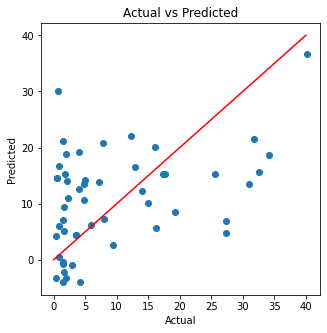

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0,40], [0,40], 'k-', color='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Even as a first attempt, this is not a very good model.  The r squared value is close to 0 and there are several predicted values below 0, meaning a player would be losing money by playing, which is obviously not true.  Ideally, the actual vs predicted plot points would all be on the red line or very near to it.

# Ridge Regression

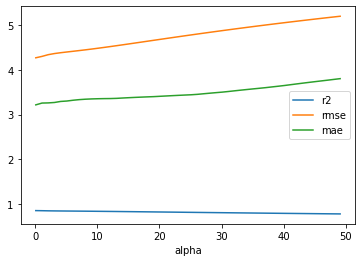

In [7]:
# find optimal alpha value
alphas = np.arange(0.1, 50, 1)
r2_scores = []
rmses = []
maes = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    rmses.append(rmse_func(ridge, X_val, y_val))
    maes.append(mean_absolute_error(y_pred, y_val))
    
plt.plot(alphas, r2_scores, label='r2')
plt.plot(alphas, rmses, label='rmse')
plt.plot(alphas, maes, label='mae')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [8]:
max_r2 = max(r2_scores)
max_index = r2_scores.index(max_r2)
best_alpha_r2 = alphas[max_index]

min_rmse = min(rmses)
min_index = rmses.index(min_rmse)
best_alpha_rmse = alphas[min_index]

min_mae = min(maes)
min_index = maes.index(min_mae)
best_alpha_mae = alphas[min_index]

print(best_alpha_r2, best_alpha_rmse, best_alpha_mae)

0.1 0.1 0.1


In [9]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

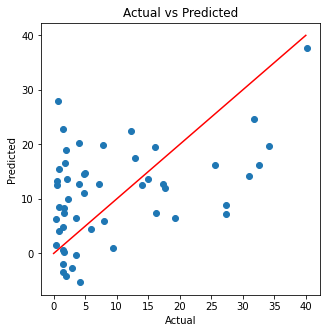

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [11]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(ridge, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.04771483169034263
The root mean square error is 10.500827374005986
The mean absolute error is 8.639490917464295


# Lasso

<ipython-input-12-783d6b314cbe>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ridge.fit(X_train, y_train)
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.913568941011, tolerance: 1.3651873115179256
  model = cd_fast.enet_coordinate_descent(


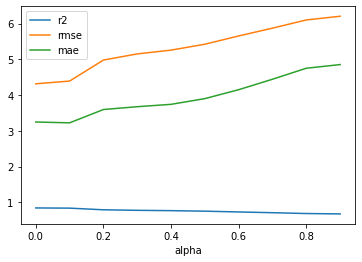

In [12]:
# find optimal alpha value
alphas = np.arange(0, 1, 0.1)
r2_scores = []
rmses = []
maes = []

for alpha in alphas:
    ridge = Lasso(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    rmses.append(rmse_func(ridge, X_val, y_val))
    maes.append(mean_absolute_error(y_pred, y_val))
    
plt.plot(alphas, r2_scores, label='r2')
plt.plot(alphas, rmses, label='rmse')
plt.plot(alphas, maes, label='mae')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [13]:
max_r2 = max(r2_scores)
max_index = r2_scores.index(max_r2)
best_alpha_r2 = alphas[max_index]

min_rmse = min(rmses)
min_index = rmses.index(min_rmse)
best_alpha_rmse = alphas[min_index]

min_mae = min(maes)
min_index = maes.index(min_mae)
best_alpha_mae = alphas[min_index]

print(best_alpha_r2, best_alpha_rmse, best_alpha_mae)

0.0 0.0 0.1


<ipython-input-14-0db4f27ea642>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  las.fit(X_train, y_train)
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.913568941011, tolerance: 1.3651873115179256
  model = cd_fast.enet_coordinate_descent(


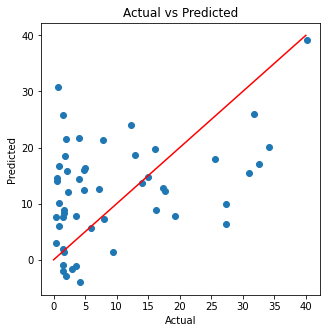

In [14]:
las = Lasso(alpha=0)
las.fit(X_train, y_train)
y_pred = las.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [15]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(las, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is -0.07818295185534141
The root mean square error is 11.173422966262681
The mean absolute error is 9.023415060625396


In general, none of the linear regression models perform very well with this dataset.  They all have very low r-squared values and high RMSE and MAE values relative to the range of salaries in the dataset.

# KNN Regression

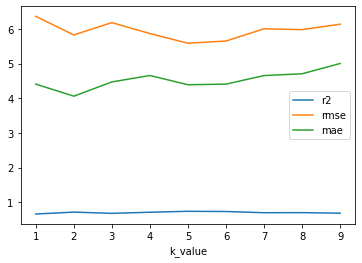

In [16]:
# optimize k
k_vals = np.arange(1, 10, 1)
r2_scores = []
rmses = []
maes = []

for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    rmses.append(rmse_func(knn, X_val, y_val))
    maes.append(mean_absolute_error(y_pred, y_val))
    
plt.plot(k_vals, r2_scores, label='r2')
plt.plot(k_vals, rmses, label='rmse')
plt.plot(k_vals, maes, label='mae')
plt.xlabel('k_value')
plt.legend()
plt.show()

In [17]:
max_r2 = max(r2_scores)
max_index = r2_scores.index(max_r2)
best_k_r2 = k_vals[max_index]

min_rmse = min(rmses)
min_index = rmses.index(min_rmse)
best_k_rmse = k_vals[min_index]

min_mae = min(maes)
min_index = maes.index(min_mae)
best_k_mae = k_vals[min_index]

print(best_k_r2, best_k_rmse, best_k_mae)

5 5 2


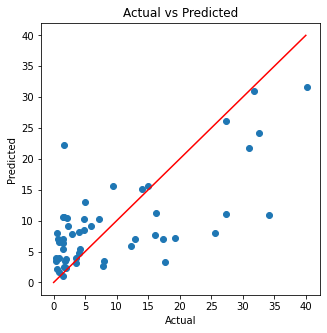

In [18]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [19]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(knn, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.47230712764370664
The root mean square error is 7.8168292064011755
The mean absolute error is 5.869499472120446


The KNN model is much better at predicting salaries than the linear regression models.  It is still not a great predictor, but the r-squared value is much higher than before, and the RMSE and MAE are lower.

# RandomForest

In [20]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=10, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=10, verbose=2)

In [22]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [23]:
rf = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=60,
                           bootstrap=False, random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

<ipython-input-23-dd99be507617>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


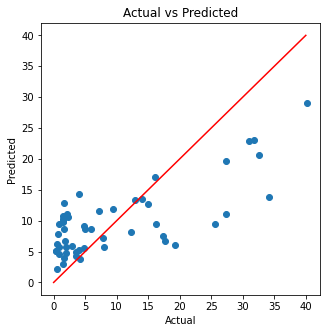

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [25]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(knn, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.5043853906704129
The root mean square error is 7.8168292064011755
The mean absolute error is 6.05189815222355


# Results

The random forest model and the KNN model had similar results, much better than the linear regression models. The random forest model can be considered marginally better than the KNN model because it has a slightly higher r-squared value and the same RMSE value, even though it has a slightly higher MAE.

In a situation where more data was available, KNN might perform better becuase it would be expected that point clusters would be more dense and closer neighbors could be selected.